# Retention Time Prediction


This notebook is prepared to be run in Google [Colaboratory](https://colab.research.google.com/). In order to train the model faster, please change the runtime of Colab to use Hardware Accelerator, either GPU or TPU.

This notebook presents a short analysis of the Loss functions task where we  train the model with different Loss functions and analyze the results to decide which loss function works best with such a task.

In [1]:
# install the dlpro package in the current environment using pip

!python -m pip install -q git+https://github.com/wilhelm-lab/dlomix.git

The available modules in the framework are as follows:

In [2]:
import numpy as np
import pandas as pd
import dlomix

## 1. Load Data

In [3]:
from dlomix.data.RetentionTimeDataset import RetentionTimeDataset

In [4]:
TRAIN_DATAPATH = 'https://raw.githubusercontent.com/wilhelm-lab/dlomix/develop/example_dataset/proteomTools_train_val.csv'
BATCH_SIZE = 64

rtdata = RetentionTimeDataset(data_source=TRAIN_DATAPATH,
                              seq_length=30, batch_size=BATCH_SIZE, val_ratio=0.2, test=False)

Now we have an RT dataset that can be used directly with standard or custom `Keras` models. This wrapper contains the splits we chose when creating it. In our case, they are training and validation splits. To get the TF Dataset, we call the attributes `.train_data` and `.val_data`.

## 2. Training

### Loss Function
Similar to the initial notebook we will initialize our model and train it.
Use train_model method with 3 different loss functions and see which will be the best fit to our problem.

In [7]:
from dlomix.models.base import RetentionTimePredictor
import tensorflow as tf
from dlomix.eval.rt_eval import TimeDeltaMetric

In [8]:
def train_model(loss_function):
  model = RetentionTimePredictor(seq_length=30)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,decay=1e-7)

  # compile the model  with the optimizer and the metrics we want to use, we can add our customer delta95 metric

  model.compile(optimizer=optimizer, 
                loss=loss_function,
                metrics=[TimeDeltaMetric(rtdata.data_mean, rtdata.data_std)])
  history = model.fit(rtdata.train_data,
                    validation_data=rtdata.val_data,
                    epochs=15)
  return history

Here we try different learning rate between 0.0001 and 0.1 and see how our losses converge.

In [9]:
loss_functions = ['mae','mse','mape']
history_loss = []
for loss_func in loss_functions:
  print('\n')
  print(loss_func)
  print('\n')
  history_loss.append(train_model(loss_func))



mae


Epoch 1/15
424/424 [==============================] - 43s 25ms/step - loss: 34.1973 - timedelta: 35.9043 - val_loss: 17.9781 - val_timedelta: 17.1498
Epoch 2/15
424/424 [==============================] - 10s 24ms/step - loss: 14.1948 - timedelta: 15.0921 - val_loss: 11.6198 - val_timedelta: 10.8734
Epoch 3/15
424/424 [==============================] - 10s 24ms/step - loss: 10.5196 - timedelta: 11.4907 - val_loss: 9.8588 - val_timedelta: 9.1457
Epoch 4/15
424/424 [==============================] - 10s 24ms/step - loss: 9.3794 - timedelta: 10.2257 - val_loss: 9.0748 - val_timedelta: 8.3598
Epoch 5/15
424/424 [==============================] - 10s 24ms/step - loss: 8.8457 - timedelta: 9.6352 - val_loss: 8.7410 - val_timedelta: 8.0543
Epoch 6/15
424/424 [==============================] - 10s 24ms/step - loss: 8.5681 - timedelta: 9.3824 - val_loss: 8.5792 - val_timedelta: 8.0009
Epoch 7/15
424/424 [==============================] - 10s 24ms/step - loss: 8.3562 - timedelta: 9.1292 - 

## 3. Analysis

After Training 3 models with different Loss functions we will analyze it to figure out which was the best learning rate to use for our problem.

Since we are comparing different loss functions here, we can't compare different models on the loss we would use then a metric to do that in our case delta95 which can help to check how far our predictions from the true values and how accurate our overall model is.

We will plot loss curve here to see if there is any sign of overfitting and check if the loss function is suitable for the problem in hand.

In [10]:
from dlomix.reports.RetentionTimeReport import RetentionTimeReport

#### Loss Function: Mean Absolute Error

In [11]:
report = RetentionTimeReport(output_path="./output", history=history_loss[0])

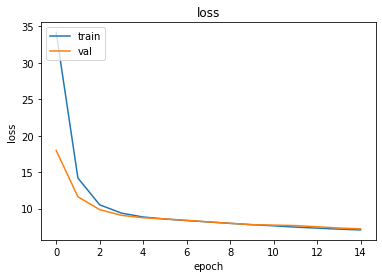

In [12]:
report.plot_keras_metric("loss")

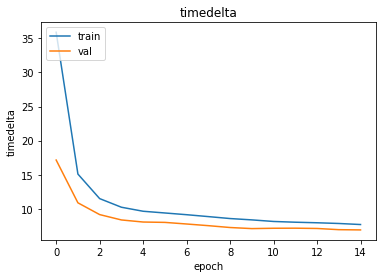

In [14]:
report.plot_keras_metric("timedelta")

#### Loss Function: Mean Squared Error



In [15]:
report = RetentionTimeReport(output_path="./output", history=history_loss[1])

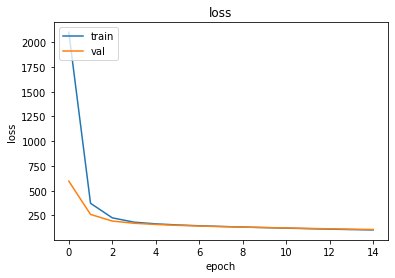

In [16]:
report.plot_keras_metric("loss")

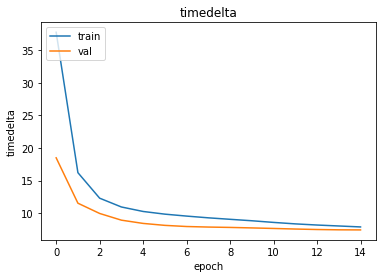

In [17]:
report.plot_keras_metric("timedelta")

#### Loss Function: Mean Absolute Percentage


In [18]:
report = RetentionTimeReport(output_path="./output", history=history_loss[2])

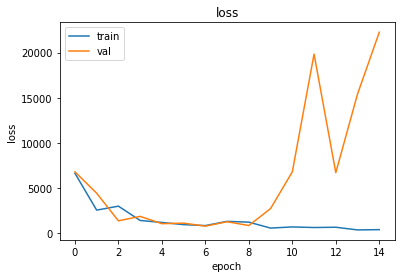

In [19]:
report.plot_keras_metric("loss")

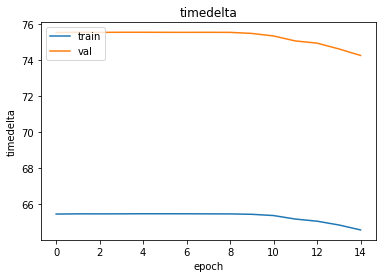

In [20]:
report.plot_keras_metric("timedelta")

## 4. Conclusion



#### Mean Absolute Percentage Error

We can see that using MAPE can't really work here, it's clear from the loss curves that val loss explode after 8 epochs and model didn't recover after this. Also for our metric it had the worst time delta.

#### Mean Absolute Error (MAE) vs. Mean Squared Error (MSE)


Both loss functions seem to work here, but plotting only loss wouldn't help to differentiate. When comparing delta95 for both we can see that Mean absolute error is slightly better which would make it the preffered loss function for this problem.

Note: This doesn't generalize we can't say MAE is better than MSE in general just based on this example.